In [ ]:
# !pip install -U "jax[tpu]" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
# !pip install vartests
!pip install numpyro
# # !pip install flax
# # !pip install aeppl==0.0.17
# !pip install blackjax
# !pip install vartests
# # !pip install jax==0.4.26

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 918.9/918.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.0/920.0 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.2
    Uninstalling statsmodels-0.14.2:
      Successfully uninstalled statsmodels-0.14.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 whic

## Stochastic Volatility model

In [ ]:
%matplotlib inline

import numpy as np
import scipy as sp
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns


import pymc as pm
import arviz as az

import os
import graphviz

import jax
from jax.lib import xla_bridge
# import blackjax
import pymc.sampling_jax

import pytensor
from pymc.pytensorf import collect_default_updates
import pytensor.tensor as pt

import cv2
import numpy as np
from google.colab import files

print(f'numpy version: {np.__version__}')
print(f'scipy version: {sp.__version__}')
print(f'arviz version: {az.__version__}')
print(f'pymc version: {pm.__version__}')
print(f'jax version: {jax.__version__}')
# print(f'platform: {xla_bridge.get_backend().platform}')
# print(f'device: {jax.devices()}')

numpy version: 1.25.2
scipy version: 1.11.4
arviz version: 0.15.1
pymc version: 5.10.4
jax version: 0.4.26


### Upload and scale data

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/My Drive/course_3

Mounted at /content/drive
/content/drive/My Drive/course_3


In [ ]:
encoding_name = 'cp1251'
hour_ahead_df1 = pd.read_csv('oes_hour_01012023_01062023.csv', sep=';', encoding=encoding_name)
hour_ahead_df2 = pd.read_csv('oes_hour_02062023_01022024.csv', sep=';', encoding=encoding_name)
hour_ahead_df = pd.concat([hour_ahead_df2, hour_ahead_df1], ignore_index=True)
rsv_hour_df = hour_ahead_df

res_name = 'Индекс равновесных цен на покупку электроэнергии, руб./МВт*ч'
rsv_hour_df.reset_index(drop=True, inplace=True)
rsv_hour_df.drop(columns=['ОЭС', 'Объем полного планового потребления, МВт*ч', 'Объем планового производства, МВт*ч',
                          'Индекс равновесных цен на продажу электроэнергии, руб.МВт*ч', 'Максимальный индекс равновесной цены, руб.МВт*ч',
                          'Минимальный индекс равновесной цены, руб.МВт*ч', 'Unnamed: 9'], inplace=True)
rsv_hour_df.rename(columns={'Дата':'Date','Час':'Hour', res_name:'Price, RUB/MWh.'}, inplace=True)

df = rsv_hour_df.copy()
df.loc[:, 'Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'].astype('str'), format='%d.%m.%Y %H')
df.sort_values(by=['Datetime'], ignore_index=True, inplace=True)
df['Diff'] = np.log(df['Price, RUB/MWh.']).diff()
df.dropna(inplace=True)
df.drop(columns=['Date', 'Hour'], inplace=True)

# Плановые отключения электроэнергии в начале августа 2023 года, в эти дни невозможны адекватные прогназирования.
index = df[df['Diff'] > df['Diff'].quantile(.9999)].index
df.drop(index, inplace=True)
df.reset_index(drop=True, inplace=True)

print(hour_ahead_df1.shape, hour_ahead_df2.shape, hour_ahead_df.shape)
df.head()

(3648, 10) (5880, 10) (9528, 3)


,"Price, RUB/MWh.",Datetime,Diff
0,1123.70,2023-01-01 01:00:00,-0.048506
1,1164.18,2023-01-01 02:00:00,0.035390
2,1114.10,2023-01-01 03:00:00,-0.043970
3,1091.61,2023-01-01 04:00:00,-0.020393
4,1092.11,2023-01-01 05:00:00,0.000458


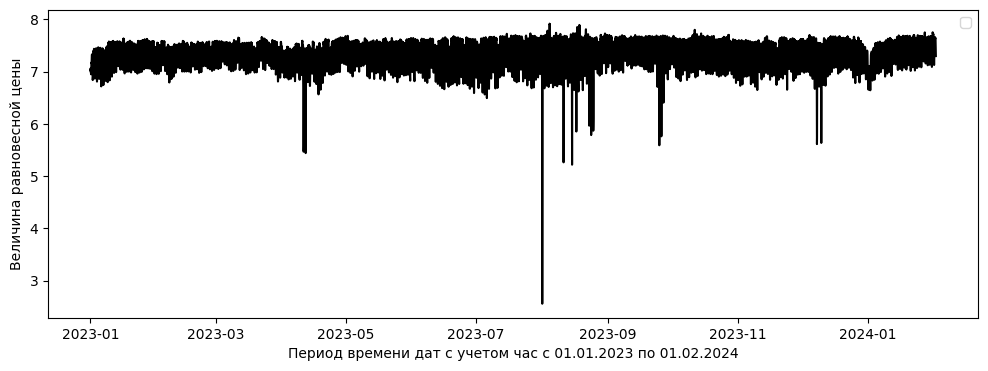

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df['Datetime'], np.log(df['Price, RUB/MWh.']), color='black')
x_label = 'Период времени дат с учетом час с 01.01.2023 по 01.02.2024'
y_label = 'Величина равновесной цены'
ax.set(xlabel=x_label, ylabel=y_label)
ax.legend();

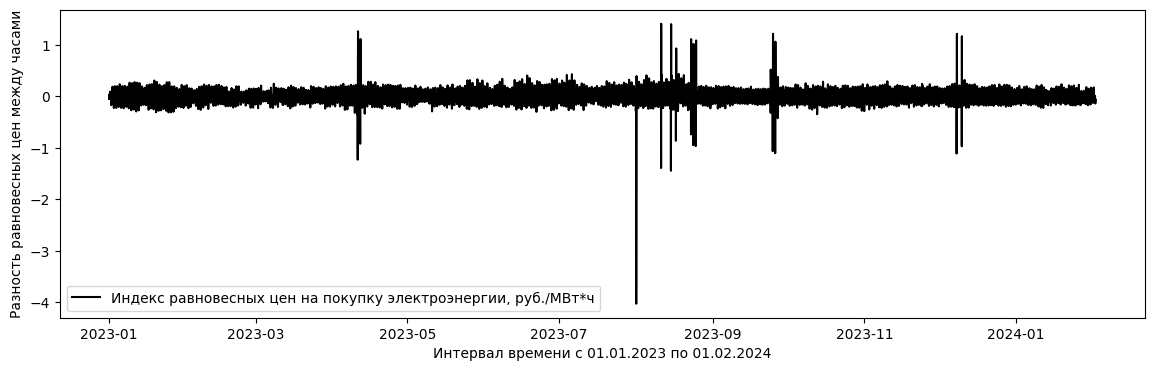

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df['Datetime'], df['Diff'], label=res_name, color='black')
x_label = 'Интервал времени с 01.01.2023 по 01.02.2024'
y_label = 'Разность равновесных цен между часами'
ax.set(xlabel=x_label, ylabel=y_label)
ax.legend();

### Build Model

In [ ]:
T = len(df)

def one_step(h_std, h_tm1, mu, phi, sigma):
      h_t = h_std * sigma + phi * (h_tm1 - mu) + mu
      return h_t

def make_stochastic_volatility_model(data):
    coords={'Datetime':data['Datetime'].values}
    with pm.Model(coords=coords) as model:

        mu = pm.Cauchy('mu', alpha=0., beta=10.)
        phi = pm.Uniform('phi', lower=-1., upper=1.)
        sigma = pm.Cauchy('sigma', alpha=0, beta=5.)

        h_std = pm.Normal('h_std', mu=0., sigma=1., dims='Datetime')
        h_init = h_std[0] / pt.sqrt(1 - phi**2) + mu

        h_innov, updates = pytensor.scan(fn=one_step,
                                        sequences=[h_std],
                                        outputs_info=[h_init],
                                        non_sequences=[mu, phi, sigma],
                                        n_steps=T,
                                        strict=True)

        h = pm.Deterministic('h', pt.concatenate([h_init[None], h_innov[:-1]]), dims='Datetime')
        y_obs = pm.Normal('y_obs', mu=0., sigma=pt.exp(h / 2), observed=df['Diff'], dims='Datetime')

    return model

stochastic_vol_model = make_stochastic_volatility_model(df)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

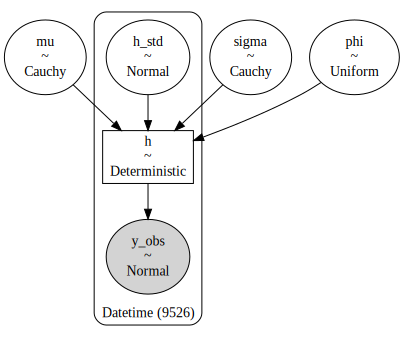

In [ ]:
dot = pm.model_to_graphviz(stochastic_vol_model)
dot.render('graph_sKSC.gv', format='png', view=False)
# files.download('graph_sKSC.gv.png')
# dot

### Check the model

In [ ]:
rng = np.random.RandomState(1234)
with stochastic_vol_model:
    trace = pm.sample_prior_predictive(samples=500, random_seed=rng)

prior_predictive = az.extract(trace, group='prior_predictive')

In [ ]:
# az.summary(trace)

In [ ]:
prior_predictive

<xarray.Dataset>
Dimensions:   (Datetime: 9526, sample: 500)
Coordinates:
  * Datetime  (Datetime) datetime64[ns] 2023-01-01T01:00:00 ... 2024-02-01T23...
  * sample    (sample) object MultiIndex
  * chain     (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * draw      (sample) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
Data variables:
    y_obs     (Datetime, sample) float64 0.0001313 6.517e+06 ... -40.3 0.03028
Attributes:
    created_at:                 2024-05-16T16:04:58.787223
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4

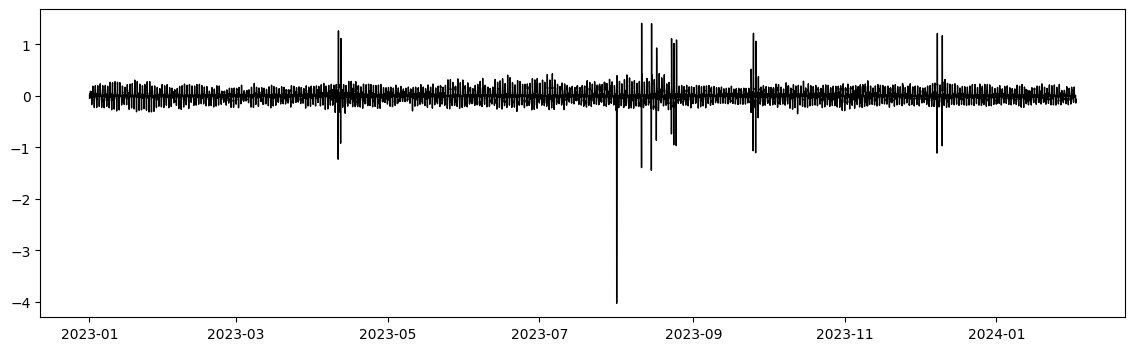

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df['Datetime'], df['Diff'], lw=1, color='black', label='Реальная величина разности равновесных цен электроэнергии')
ax.plot(
    prior_predictive['Datetime'],
    prior_predictive['y_obs'][:, 0::100000],
    'g',
    alpha=0.5,
    lw=1,
    zorder=-10,
    label='Предсказуемый волатильность изменений цен электроэнергии'
)

max_observed, max_predicted = np.max(np.abs(df['Diff'])), np.max(np.abs(prior_predictive['y_obs'].values))

### Fit Model

In [ ]:
# rng = np.random.RandomState(1234)
# with stochastic_vol_model:
#     trace.extend(pm.sampling.jax.sample_blackjax_nuts(random_seed=rng, chain_method='parallel'))

# posterior = az.extract(trace)
# posterior['exp_h'] = np.exp(posterior['h'])

In [ ]:
rng = np.random.RandomState(1234)
with stochastic_vol_model:
    trace.extend(pm.sampling.jax.sample_numpyro_nuts(random_seed=rng, chain_method='parallel'))

posterior = az.extract(trace)
posterior['exp_h'] = np.exp(posterior['h'])

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
posterior

NameError: name 'posterior' is not defined

In [ ]:
with stochastic_vol_model:
    trace.extend(pm.sample_posterior_predictive(trace, random_seed=rng))

posterior_predictive = az.extract(trace, group='posterior_predictive')

In [ ]:
posterior_predictive

<xarray.Dataset>
Dimensions:   (Datetime: 9526, sample: 4000)
Coordinates:
  * Datetime  (Datetime) datetime64[ns] 2023-01-01T01:00:00 ... 2024-02-01T23...
  * sample    (sample) object MultiIndex
  * chain     (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw      (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    y_obs     (Datetime, sample) float64 -0.01882 -0.06721 ... 0.02264 0.1168
Attributes:
    created_at:                 2024-05-16T16:14:32.301017
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


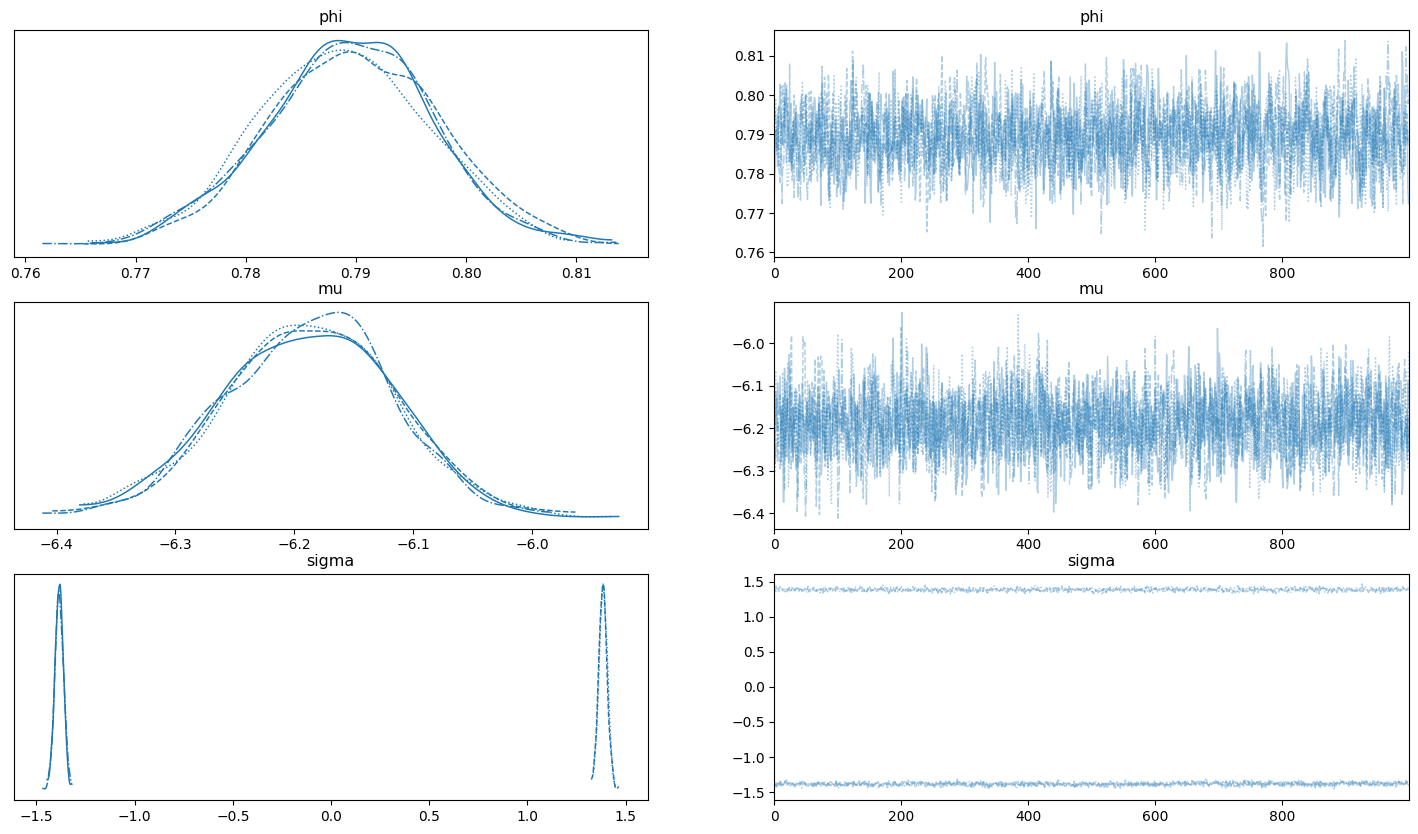

In [ ]:
az.plot_trace(trace, var_names=['phi', 'mu', 'sigma'], figsize=(18, 10));

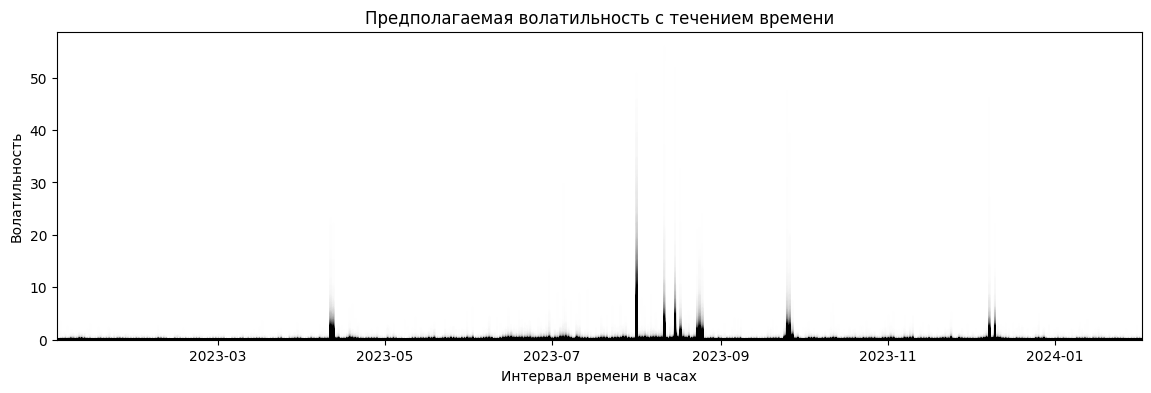

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = posterior['exp_h']
x_vals = y_vals['Datetime']

plt.plot(x_vals, y_vals, 'k', alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title='Предполагаемая волатильность с течением времени', xlabel='Интервал времени в часах', ylabel='Волатильность');

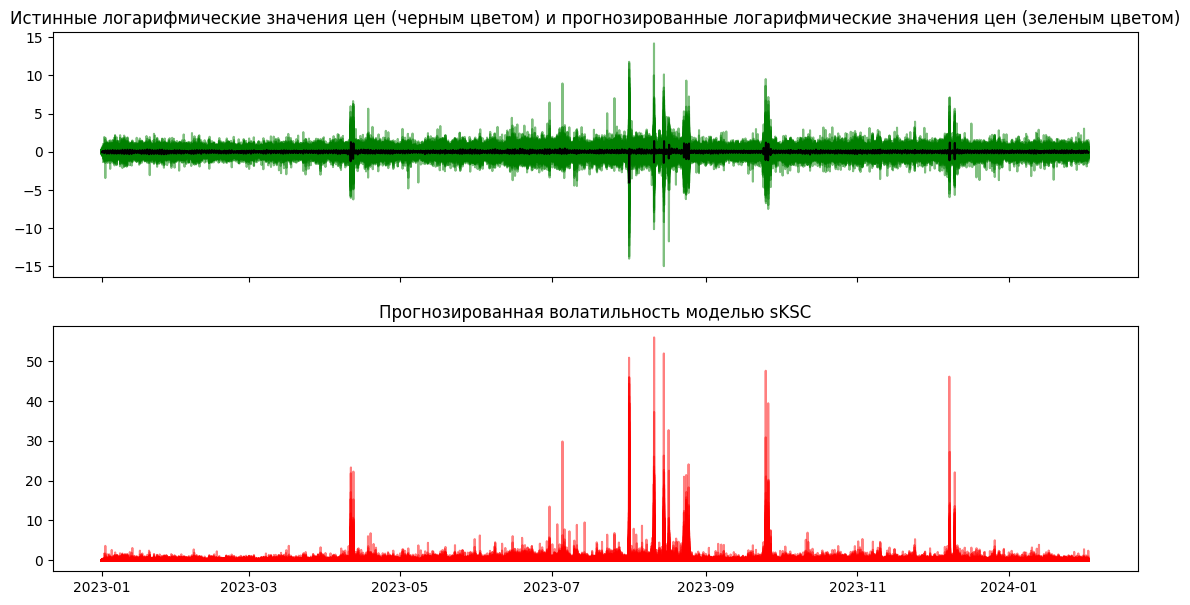

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)

pred_y_vals = posterior_predictive['y_obs']
pred_x_vals = pred_y_vals['Datetime']

axes[0].plot(df['Datetime'], df['Diff'], label=res_name, color='black')
axes[0].plot(pred_x_vals, pred_y_vals, label='апостериорные логарифмические значения', color='g', alpha=0.5, zorder=-10)
axes[0].set_title('Истинные логарифмические значения цен (черным цветом) и прогнозированные логарифмические значения цен (зеленым цветом)')

axes[1].plot(x_vals, y_vals, 'r', alpha=0.5)
axes[1].set_title('Предсказуемая волатильность моделью sKSC');

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

y_obs = np.exp(trace.posterior_predictive['y_obs'].mean(('chain', 'draw')))
y = np.exp(df['Diff'])

print(f'RMSE: {mean_squared_error(y, y_obs, squared=False)}')
print(f'MAPE: {mean_absolute_percentage_error(y, y_obs)}')
print(f'MAE: {mean_squared_error(y, y_obs)}')
print(f'R^2: {r2_score(y, y_obs)}')

RMSE: 0.12505126407781023
MAPE: 0.06924228206700142
MAE: 0.01563781864745823
R^2: -0.0028650726501049384
